#### Fix Frame PDB Files for Probity Analysis

In [3]:
import os

def editPdb(file_name):
    # get all lines in pdb
    with open(file_name, "r") as f:
        all_text = f.read()

    split_lines = all_text.split("\n")
    finished_lines = []

    # go through each line
    for line in split_lines:

        # split line on space.
        split_words = line.split(" ")

        if(split_words[0] == "ATOM"):

            # if index 3 (resname) is HSD/HSE make it HIS
            ind = getTrueIndex(3, split_words)
            if(split_words[ind] == "HSD" or split_words[ind] == "HSE"):
                split_words[ind] = "HIS"
            
            # if index 3 (resname) is FAD make index 4 F
            ind = getTrueIndex(3, split_words)
            if(split_words[ind] == "FAD"):
                ind = getTrueIndex(4, split_words)
                split_words[ind] = "F"
            elif(split_words[ind] == "SAH"):
                ind = getTrueIndex(4, split_words)
                split_words[ind] = "S"

            # if index 3(resname) is ILE if index 2 (atom name) is CD, rename CD1
            ind = getTrueIndex(3, split_words)
            ind2 = getTrueIndex(2, split_words)
            if(split_words[ind] == "FAD" and split_words[ind2] == "CD"):
                split_words[ind2] = "CD1"
                del split_words[ind2+1]
            
            # if index 5 (resnum) is 656 if index 2 (atom name) is OT1 rename OXT
            ind = getTrueIndex(5, split_words)
            ind2 = getTrueIndex(2, split_words)
            if(split_words[ind] == "656" and split_words[ind2] == "OT1"):
                split_words[ind2] = "OXT"
            
            # if index 5 (resnum) is 656 if index 2 (atom name) is OT2 rename O
            ind = getTrueIndex(5, split_words)
            ind2 = getTrueIndex(2, split_words)
            if(split_words[ind] == "656" and split_words[ind2] == "OT2"):
                split_words[ind2] = "O"
                split_words.insert(ind2+1, "")
                split_words.insert(ind2+1, "")
            
            finished_lines.append(" ".join(split_words))
        else:
            finished_lines.append(line)

    #after going through every line print, them all into file again
    op = "\n".join(finished_lines)
    with open(file_name, "w") as f:
        f.write(op)


def getTrueIndex(index, split_words):
    # will return the "true" index of some text based on its theoretical index
    fake_index = 0
    ret_index = 0
    while True:
        if(split_words[ret_index] != ""):
            if(fake_index == index):
                return ret_index
            fake_index = fake_index + 1
        
        ret_index = ret_index + 1
            



# for each run folder
#run_folders = ["pose_dcds/G196F_bottomLeft_r32/mut2_selected_frame","pose_dcds/G196F_bottomLeft_r32/mut3_selected_frame",
#               "pose_dcds/G196F_topLeft_r23/mut2_selected_frame","pose_dcds/G196F_topRight_r1/mut1_selected_frame",
#               "pose_dcds/WT_bottomLeft_r2/wt2_selected_frame","pose_dcds/WT_bottomRightDense_r3/wt3_selected_frame",
#               "pose_dcds/WT_bottomRightOther_r1/wt1_selected_frame"]
run_folders = ["WT_v11/Run2_frame", "WT_v11/Run3_frame",
               "G196F_v1/Run1_frame", "G196F_v1/Run2_frame", "G196F_v1/Run3_frame"]

# Open every file. On each file run the editing program
for run_folder in run_folders:
    print(run_folder)
    files = os.listdir(run_folder)
    for file in files:
        editPdb(os.path.join(run_folder,file))

WT_v11/Run2_frame
WT_v11/Run3_frame
G196F_v1/Run1_frame
G196F_v1/Run2_frame
G196F_v1/Run3_frame


#### Calculate Average G For Each Run Type (Boltzmann)

In [4]:
run_types = ['WT_v11','G196F_v1'] # add the name of each 
run_count = ['Run1','Run2','Run3'] # add the name of each 
frames = ["{:04}".format(i) for i in range(1,401)] # change last number based on number of frames + 1
sim_length = 200 #how long the simulation is in nanoseconds

In [5]:
import numpy as np

def calculate_boltzmann_weights(energy, temperature, boltzmann_constant):
    """
    Calculates Boltzmann weights for a set of energy states.

    Args:
        energies (float): Array of energies for each state.
        temperature (float): Temperature in appropriate units (e.g., Kelvin).
        boltzmann_constant (float): Boltzmann constant in appropriate units.

    Returns:
        float: boltzmann weight.
    """
    beta = 1 / (boltzmann_constant * temperature)
    weight = np.exp(-energy * beta)
    
    return weight


In [7]:
for run_type in run_types:
    totalRunEnergies = []
    totalRunWeights = []
    for run in run_count:
        with open(f"D:\\Research Lab\\MD Sim\\completed_md\\data_storage\\WT_G196F\\SAH_free_energy\\{run_type.split("_")[0]}_r{run[-1]}_G.txt", "r") as f:
            op = f.read()
        
        # go through every line and get list of all G values
        line_split = op.split("\n")

        freeEnergies = []
        weights = []

        for line in line_split:
            words = line.split("\t")
            if len(words) > 1:
                freeEnergy = float(words[1]) # free energy is in Kcal/mol
                boltzmannWeight = calculate_boltzmann_weights(freeEnergy*1000, 310, 1.987) # 1.987 is cal/mol*K
                freeEnergies.append(freeEnergy)
                weights.append(boltzmannWeight)


        # calculate the average, print it out
        averageEnergy = np.average(freeEnergies, weights=weights)
        totalRunEnergies.extend(freeEnergies)
        totalRunWeights.extend(weights)
        print(f"{run_type.split("_")[0]}_r{run[-1]}: {averageEnergy} kJ")
    totalAverageEnergy = np.average(totalRunEnergies, weights=totalRunWeights)
    print(f"{run_type.split("_")[0]}: {totalAverageEnergy} kJ")
    



WT_r1: -6.988216589945581 kJ
WT_r2: -7.309061792519111 kJ
WT_r3: -7.297072463218648 kJ
WT: -7.22761748249315 kJ
G196F_r1: -7.304852262684325 kJ
G196F_r2: -7.714751617210124 kJ
G196F_r3: -7.402754375179098 kJ
G196F: -7.520617981792365 kJ


#### Average G for Each Run Using Only Common Poses (Boltzmann)

In [6]:
files = [[r"F:\Research Lab\MD Sim\completed_md\data_storage\WT_G196F\pose_free_energy\G_topRight_r1_1.txt", r"F:\Research Lab\MD Sim\completed_md\data_storage\WT_G196F\pose_free_energy\G_topLeft_r23_2.txt",
        r"F:\Research Lab\MD Sim\completed_md\data_storage\WT_G196F\pose_free_energy\G_bottomLeft_r32_3.txt"], [r"F:\Research Lab\MD Sim\completed_md\data_storage\WT_G196F\pose_free_energy\WT_bottomRightOther_r1_1.txt",
        r"F:\Research Lab\MD Sim\completed_md\data_storage\WT_G196F\pose_free_energy\WT_bottomLeft_r2_2.txt", r"F:\Research Lab\MD Sim\completed_md\data_storage\WT_G196F\pose_free_energy\WT_bottomRightDense_r3_3.txt"]]


for run_type in files:
    totalRunEnergies = []
    totalRunWeights = []
    for run in run_type:
        with open(run, "r") as f:
            op = f.read()
        
        # go through every line and get list of all G values
        line_split = op.split("\n")

        freeEnergies = []
        weights = []

        for line in line_split:
            words = line.split("\t")
            if len(words) > 1:
                freeEnergy = float(words[1]) # free energy is in Kcal/mol
                boltzmannWeight = calculate_boltzmann_weights(freeEnergy*1000, 310, 1.987) # 1.987 is cal/mol*K
                freeEnergies.append(freeEnergy)
                weights.append(boltzmannWeight)


        # calculate the average, print it out
        averageEnergy = np.average(freeEnergies, weights=weights)
        totalRunEnergies.extend(freeEnergies)
        totalRunWeights.extend(weights)
        print(f"{run.split("\\")[-1].split(".")[0]}: {averageEnergy} kJ")
    totalAverageEnergy = np.average(totalRunEnergies, weights=totalRunWeights)
    print(f"{totalAverageEnergy} kJ")

G_topRight_r1_1: -8.615721052480254 kJ
G_topLeft_r23_2: -8.744600726307269 kJ
G_bottomLeft_r32_3: -8.61512928815085 kJ
-8.651260763468953 kJ
WT_bottomRightOther_r1_1: -8.610246047586628 kJ
WT_bottomLeft_r2_2: -8.422196643686993 kJ
WT_bottomRightDense_r3_3: -8.82886456005535 kJ
-8.7253774572951 kJ


#### Violin Plots of Free Energy Distribution

In [9]:
def frameEnergy(run_types, run_count):
    allEnergies = {}
    allWeights = {}
    for run_type in run_types:
        allEnergies[run_type] = {}
        allWeights[run_type] = {}
        for run in run_count:
            with open(f"D:\\Research Lab\\MD Sim\\completed_md\\data_storage\\WT_G196F\\SAH_free_energy\\{run_type.split("_")[0]}_r{run[-1]}_G.txt", "r") as f:
                op = f.read()
            
            # go through every line and get list of all G values
            line_split = op.split("\n")

            allEnergies[run_type][run] = []
            allWeights[run_type][run] = []

            for line in line_split:
                words = line.split("\t")
                if len(words) > 1:
                    freeEnergy = float(words[1]) # free energy is in Kcal/mol
                    boltzmannWeight = calculate_boltzmann_weights(freeEnergy*1000, 310, 1.987) # 1.987 is cal/mol*K
                    allEnergies[run_type][run].append(freeEnergy)
                    allWeights[run_type][run].append(boltzmannWeight)
    return allEnergies, allWeights

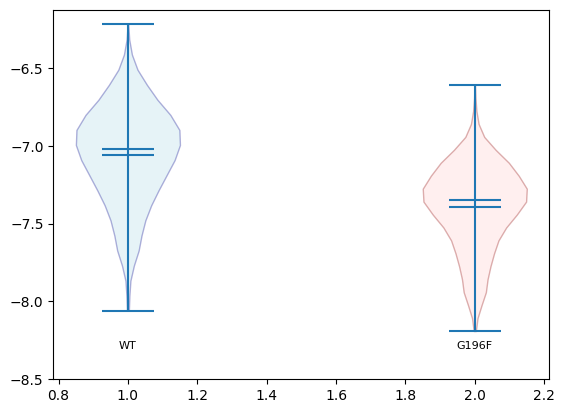

In [27]:
import matplotlib.pyplot as plt

# get data
runs = [1,2]
allEnergies, allWeights = frameEnergy(run_types, run_count)
energy = []
for run_type in run_types:
    runEnergy = []
    for run in run_count:
        runEnergy.extend(allEnergies[run_type][run])
    energy.append(runEnergy)


# create plot
fig, ax = plt.subplots(figsize=[6.4, 4.8])

parts = ax.violinplot(energy, runs, points=20, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)


pc = parts['bodies'][0]
pc.set_facecolor('lightblue')  # Set fill color
pc.set_edgecolor('darkblue')   # Set border color
pc = parts['bodies'][1]
pc.set_facecolor('#FFCCCB')  # Set fill color
pc.set_edgecolor('#8b0000')   # Set border color

ax.annotate('WT',xy=(1, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)
ax.annotate('G196F',xy=(2, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)

ax.set_ylim(-8.5,-6.125)

plt.show()

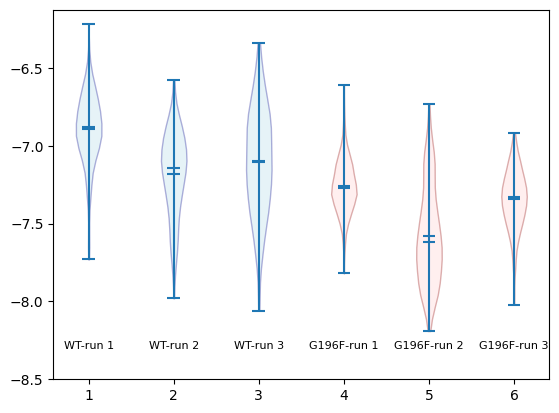

In [14]:
import matplotlib.pyplot as plt

# get data
runs = [1,2,3,4,5,6]
allEnergies, allWeights = frameEnergy(run_types, run_count)
energy = []
for run_type in run_types:
    for run in run_count:
        energy.append(allEnergies[run_type][run])


# create plot
fig, ax = plt.subplots(figsize=[6.4, 4.8])

parts = ax.violinplot(energy, runs, points=20, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True)


for pc in parts['bodies'][0:3]:
    pc.set_facecolor('lightblue')  # Set fill color
    pc.set_edgecolor('darkblue')   # Set border color
for pc in parts['bodies'][3:]:
    pc.set_facecolor('#FFCCCB')  # Set fill color
    pc.set_edgecolor('#8b0000')   # Set border color
ax.annotate('WT-run 1',xy=(1, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)
ax.annotate('WT-run 2',xy=(2, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)
ax.annotate('WT-run 3',xy=(3, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)
ax.annotate('G196F-run 1',xy=(4, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)
ax.annotate('G196F-run 2',xy=(5, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)
ax.annotate('G196F-run 3',xy=(6, -8.25),horizontalalignment='center', verticalalignment='top',fontsize=8)

ax.set_ylim(-8.5,-6.125)

plt.show()